Colab で動かす場合、ランタイムを GPU にしてください。

# はじめに

モデルベース方策は、環境のモデルを用いて行動選択を行う方法です。

<div style="text-align: center">
<img width="450" alt="model-based.png (87.9 kB)" src="https://img.esa.io/uploads/production/attachments/21189/2024/01/17/160121/ff4cf22b-8143-4402-a6ce-d28dbbcd43f2.png">
<br>モデルベース方策</br>
</div>

ここでは TD-MPC における行動最適化で用いられる MPPI（Model Predictive Path Integral）を実装します。

MPPI は、行動シーケンスのサンプルを生成し、それに基づいて行動決定を行う方法です。このアルゴリズムは CMA-ES などの進化計算に類似しており、以下のステップで最適解を求めます。

1. 多変量ガウス分布から $n$ 本の行動シーケンスの候補を生成
2. 生成された候補の中から報酬和が上位の $k$ 本をエリートとして選択
3. エリートの行動シーケンスに基づき、多変量ガウス分布のパラメータを更新

詳細は、以下のコードまたは [TD-MPC 論文](https://arxiv.org/abs/2203.04955)の第３章を参照してください。

# 実装

### ライブラリの準備

実装では、以下のライブラリを使用します。
- [JAX](https://jax.readthedocs.io/en/latest/index.html)：GPU や JIT コンパイルによる高速化が可能な数値計算ライブラリ
- [Flax](https://github.com/google/flax)：JAX のための NN ライブラリ
- [Optax](https://github.com/google-deepmind/optax)：JAX/Flax で定義されたモデルのパラメータを更新するためのライブラリ
- [Brax](https://github.com/google/brax)：JAX で実装された物理シミュレータ

JAX/Flax/Optax の使い方は以下のページが参考になります：

- [JAX/Flax 入門](https://speakerdeck.com/enakai00/flax-ru-men)  [[code](https://github.com/enakai00/JAX_workshop)]
- [PyTorch to JAX 移行ガイド (MLP 学習編)](https://zenn.dev/jellied_unagi/articles/d986044a425e94)

また、Brax の使い方は以下のページが参考になります：
- [Google 製 GPU 対応物理シミュレータ Brax の調査](https://zenn.dev/ymd_h/articles/092e3888e19046)
- [Jax・Brax・Haiku で GPU 引きこもり学習](https://kngwyu.github.io/rlog/ja/2021/12/18/jax-brax-haiku.html)

Colab で動かす場合、brax をはじめにインストールする必要があります。

In [ ]:
# ライブラリのインストール
!pip install brax -q

In [ ]:
# ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax

from IPython.display import HTML, clear_output
from tqdm.notebook import tqdm
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState
from brax import envs
from brax.io import html

# 乱数のシードを設定
key = jax.random.PRNGKey(42)

### 環境の定義
強化学習を実行するための環境を設定します。ここでは例として、`halfcheetah` 環境を用いていますが、`hopper` や `ant` など他の環境に変更することも可能です。利用可能な環境の一覧は、[`brax.envs.__init__.py`](https://github.com/google/brax/blob/main/brax/envs/__init__.py) で確認できます。

環境のリセット（`env.reset`）やステップ実行（`env.step`）は、`jax.jit` 関数を用いることで高速化することができます。

In [ ]:
env = envs.get_environment(env_name='halfcheetah', backend='positional')
episode_length = 200

# コンパイル設定
env_reset = jax.jit(env.reset)
env_step = jax.jit(env.step)

# 状態と行動の次元を取得
obs_dim = env.observation_size
action_dim = env.action_size

print(f"obs_dim: {obs_dim}, action_dim: {action_dim}")

obs_dim: 17, action_dim: 6


## 環境モデルが既知のケース
まず、環境のステップ関数 `env_step` を使用して、行動を最適化するケースを考えます。

In [ ]:
# MPPI のハイパーパラメータ
horizon = 25
iterations = 4
num_samples = 512
num_elites = 64
temperature = 0.25

### MPPI 関数

In [ ]:
@jax.jit
def mppi_sim(key, env_state_init, actions_mean):

    def sample_action_sequence(key, actions_mean, actions_std):
        eps = jax.random.normal(key, (num_samples, horizon, action_dim))
        actions_batch = actions_mean[None] + actions_std[None] * eps
        actions_batch = jnp.clip(actions_batch, -1.0, 1.0)
        return actions_batch


    def compute_return(env_state, actions):
        def rollout(env_state, action):
            env_state = env_step(env_state, action)
            return env_state, env_state.reward

        _, rewards = jax.lax.scan(rollout, env_state, actions)
        return jnp.sum(rewards)


    def get_elite(key, actions_mean, actions_std):

        # 行動シーケンスをサンプリング
        key, subkey = jax.random.split(key)
        actions_batch = sample_action_sequence(subkey, actions_mean, actions_std)

        # 行動シーケンスの報酬和を評価
        V_func = lambda actions: compute_return(env_state_init, actions)
        V_batch = jax.vmap(V_func)(actions_batch)

        # 報酬和をもとにエリートを選択
        V_elite, elite_index = jax.lax.top_k(V_batch, num_elites)
        actions_elite = actions_batch[elite_index]

        return V_elite, actions_elite


    def update_params(mean, std, V_elite, actions_elite):

        score = jnp.exp(temperature * (V_elite - jnp.max(V_elite)))
        score = score[:, None, None] / (jnp.sum(score) + 1e-9)

        mean = jnp.sum(score * actions_elite, axis=0)
        std = jnp.sqrt(jnp.sum(score * (actions_elite - mean[None])**2, axis=0))

        return mean, std


    def body_fun(_, val):
        key, actions_mean, actions_std = val

        # サンプル分布からエリートを取得
        key, subkey = jax.random.split(key)
        V_elite, actions_elite = get_elite(subkey, actions_mean, actions_std)

        # サンプル分布のパラメータを更新
        actions_mean, actions_std \
            = update_params(actions_mean, actions_std, V_elite, actions_elite)

        return (key, actions_mean, actions_std)


    # サンプル分布の標準偏差を初期化
    actions_std = jnp.ones((horizon, action_dim))

    # MPPI のループを実行
    init_val = (key, actions_mean, actions_std)
    val = jax.lax.fori_loop(0, iterations, body_fun, init_val)
    key, actions_mean, actions_std = val

    # サンプル分布からエリートを取得
    key, subkey = jax.random.split(key)
    V_elite, actions_elite = get_elite(subkey, actions_mean, actions_std)

    # 最良の行動シーケンスの先頭の行動を取得
    action_best = actions_elite[jnp.argmax(V_elite), 0]

    return action_best, actions_mean

### 実行

In [ ]:
# サンプル分布の平均を初期化
actions_mean = jnp.zeros((horizon, action_dim))

# 環境の初期化
key, subkey = jax.random.split(key)
env_state = env_reset(subkey)

reward_sum = 0.0
rollout = [env_state.pipeline_state]

for _ in tqdm(range(episode_length)):

    # MPPI による行動の最適化
    key, subkey = jax.random.split(key)
    action, actions_mean = mppi_sim(subkey, env_state, actions_mean)

    # 環境で行動を実行
    env_state = env_step(env_state, action)

    reward_sum += env_state.reward
    rollout.append(env_state.pipeline_state)

    # サンプル分布の平均を１ステップ分ずらす
    actions_mean = jnp.concatenate([actions_mean[1:], jnp.zeros((1, action_dim))])

print(f"reward_sum: {reward_sum}")
sim_reward_sum = reward_sum

HTML(html.render(env.sys.replace(dt=env.dt), rollout))

  0%|          | 0/200 [00:00<?, ?it/s]

reward_sum: 733.9458618164062


## 環境モデルが未知のケース
次に、環境との相互作用からモデルを学習するケースを考えます。

In [ ]:
# モデル学習用のハイパーパラメータ
rho = 0.5
learning_rate = 0.001
total_timesteps = 50000
learning_starts = 5000
batch_size = 512
grad_clip_norm = 10.0

### モデルの定義

In [ ]:
class Dynamics(nn.Module):
    obs_dim: int

    @nn.compact
    def __call__(self, obs, action):
        x = jnp.concatenate([obs, action], -1)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(self.obs_dim)(x)
        return x


class Reward(nn.Module):
    @nn.compact
    def __call__(self, obs, action):
        x = jnp.concatenate([obs, action], -1)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(256, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.LayerNorm()(x)
        x = nn.elu(x)
        x = nn.Dense(1, kernel_init=orthogonal(1e-5), bias_init=constant(0))(x)
        return x

# モデルの定義
dynamics = Dynamics(obs_dim)
reward_fn = Reward()

# コンパイル設定
dynamics.apply = jax.jit(dynamics.apply)
reward_fn.apply = jax.jit(reward_fn.apply)

# Optimizer の定義
key, dynamics_key, reward_key = jax.random.split(key, 3)

dynamics_state = TrainState.create(
    apply_fn = dynamics.apply,
    params = dynamics.init(dynamics_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    tx = optax.chain(
        optax.clip_by_global_norm(grad_clip_norm),
        optax.adam(learning_rate=learning_rate)
    )
)

reward_state = TrainState.create(
    apply_fn = reward_fn.apply,
    params = reward_fn.init(reward_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    tx = optax.chain(
        optax.clip_by_global_norm(grad_clip_norm),
        optax.adam(learning_rate=learning_rate)
    )
)

### リプレイバッファ

In [ ]:
class ReplayBuffer():

    def __init__(self, total_timesteps, episode_length, obs_dim, action_dim):

        # バッファの定義
        num_episode = (total_timesteps // episode_length) + 1
        self.obs_buffer = np.empty((num_episode, episode_length + 1, obs_dim), dtype=np.float32)
        self.action_buffer = np.empty((num_episode, episode_length, action_dim), dtype=np.float32)
        self.reward_buffer = np.empty((num_episode, episode_length, 1), dtype=np.float32)

        self.episode_length = episode_length
        self.iter = 0


    def add(self, obss, actions, rewards):

        # バッファにシーケンスを格納
        self.obs_buffer[self.iter] = obss
        self.action_buffer[self.iter] = actions
        self.reward_buffer[self.iter] = rewards[:, None]
        self.iter += 1


    def sample(self, batch_size, horizon):

        # バッファから取得する要素の index をサンプリング
        idx = np.random.randint(self.iter, size=batch_size)
        idy = np.random.randint(self.episode_length - horizon, size=batch_size)

        obs_dim = self.obs_buffer.shape[2]
        action_dim = self.action_buffer.shape[2]

        # バッファからデータを取得
        obss = np.empty((horizon+1, batch_size, obs_dim), dtype=np.float32)
        actions = np.empty((horizon, batch_size, action_dim), dtype=np.float32)
        rewards = np.empty((horizon, batch_size, 1), dtype=np.float32)
        for t in range(horizon):
            obss[t] = self.obs_buffer[idx, idy+t]
            actions[t] = self.action_buffer[idx, idy+t]
            rewards[t] = self.reward_buffer[idx, idy+t]
        obss[horizon] = self.obs_buffer[idx, idy+horizon]
        return jnp.array(obss), jnp.array(actions), jnp.array(rewards)

rb = ReplayBuffer(total_timesteps, episode_length, obs_dim, action_dim)

### 学習用関数

In [ ]:
@jax.jit
def update_dynamics(
    dynamics_state,
    reward_state,
    obss,
    actions,
    rewards,
):

    def loss_fn(dynamics_params, reward_params):

        def rollout(obs, action):
            obs_pred = dynamics.apply(dynamics_params, obs, action)
            reward_pred = reward_fn.apply(reward_params, obs, action)
            return obs_pred, (obs_pred, reward_pred)

        # 環境モデルによる予測値を計算
        _, (obss_pred, rewards_pred) = jax.lax.scan(rollout, obss[0], actions)

        # 直近の誤差を重視するための係数
        rhos = (rho ** jnp.arange(horizon))
        rhos = jnp.expand_dims(rhos, axis=(1,2))

        # 二乗和誤差の計算
        transition_loss = jnp.mean(rhos * (obss[1:] - obss_pred) ** 2)
        reward_loss = jnp.mean(rhos * (rewards - rewards_pred) ** 2)

        return transition_loss + reward_loss

    # 勾配を計算
    grad_fn = jax.value_and_grad(loss_fn, argnums=(0,1))
    loss_value, grads = grad_fn(dynamics_state.params, reward_state.params)

    # パラメータを更新
    dynamics_state = dynamics_state.apply_gradients(grads=grads[0])
    reward_state = reward_state.apply_gradients(grads=grads[1])
    return dynamics_state, reward_state, loss_value

### MPPI 関数

In [ ]:
@jax.jit
def mppi_with_model(
    key,
    obs_init,
    dynamics_state,
    reward_state,
    actions_mean,
    exploration_std,
):

    def sample_action_sequence(key, actions_mean, actions_std):
        eps = jax.random.normal(key, (num_samples, horizon, action_dim))
        actions_batch = actions_mean[None] + actions_std[None] * eps
        actions_batch = jnp.clip(actions_batch, -1.0, 1.0)
        return actions_batch


    def compute_return(obs, actions):
        def rollout(obs, action):
            next_obs = dynamics.apply(dynamics_state.params, obs, action)
            reward = reward_fn.apply(reward_state.params, obs, action)
            return next_obs, reward

        _, rewards = jax.lax.scan(rollout, obs, actions)
        return jnp.sum(rewards)


    def get_elite(key, actions_mean, actions_std):

        # 行動シーケンスをサンプリング
        key, subkey = jax.random.split(key)
        actions_batch = sample_action_sequence(subkey, actions_mean, actions_std)

        # 行動シーケンスの報酬和を評価
        V_func = lambda actions: compute_return(obs_init, actions)
        V_batch = jax.vmap(V_func)(actions_batch)

        # 報酬和をもとにエリートを選択
        V_elite, elite_index = jax.lax.top_k(V_batch, num_elites)
        actions_elite = actions_batch[elite_index]

        return V_elite, actions_elite


    def update_params(mean, std, V_elite, actions_elite):

        score = jnp.exp(temperature * (V_elite - jnp.max(V_elite)))
        score = score[:, None, None] / (jnp.sum(score) + 1e-9)

        mean = jnp.sum(score * actions_elite, axis=0)
        std = jnp.sqrt(jnp.sum(score * (actions_elite - mean[None])**2, axis=0))
        return mean, std


    def body_fun(_, val):
        key, actions_mean, actions_std = val

        # サンプル分布からエリートを取得
        key, subkey = jax.random.split(key)
        V_elite, actions_elite = get_elite(subkey, actions_mean, actions_std)

        # サンプル分布のパラメータを更新
        actions_mean, actions_std \
            = update_params(actions_mean, actions_std, V_elite, actions_elite)

        return (key, actions_mean, actions_std)


    # サンプル分布の標準偏差を初期化
    actions_std = jnp.ones((horizon, action_dim))

    # MPPI のループを実行
    init_val = (key, actions_mean, actions_std)
    val = jax.lax.fori_loop(0, iterations, body_fun, init_val)
    key, actions_mean, actions_std = val

    # サンプル分布からエリートを取得
    key, subkey = jax.random.split(key)
    V_elite, actions_elite = get_elite(subkey, actions_mean, actions_std)

    # 最良の行動シーケンスの先頭の行動を取得
    action_best = actions_elite[jnp.argmax(V_elite), 0]

    # 探索を促進するためのノイズを印加
    eps = jax.random.normal(key, (action_dim, ))
    action_best = action_best + exploration_std * eps
    action_best = jnp.clip(action_best, -1.0, 1.0)

    return action_best, actions_mean

### データ収集用関数

In [ ]:
@jax.jit
def random_rollout(key):
    def body_fun(env_state, key):
        action = jax.random.uniform(key, (action_dim,), minval=-1.0, maxval=1.0)
        env_state = env_step(env_state, action)
        return env_state, (env_state.obs, action, env_state.reward)

    # 環境の初期化
    key, subkey = jax.random.split(key)
    env_state = env_reset(subkey)
    init_obs = env_state.obs[None]

    # ロールアウトを実行
    keys = jax.random.split(key, episode_length)
    _, (obss, actions, rewards) = jax.lax.scan(body_fun, env_state, keys)

    obss = jnp.concatenate([init_obs, obss], axis=0)
    return obss, actions, rewards


@jax.jit
def policy_rollout(key, dynamics_state, reward_state):

    def body_fun(carry, key):
        actions_mean, env_state = carry
        action, actions_mean = mppi_with_model(
            key,
            env_state.obs,
            dynamics_state,
            reward_state,
            actions_mean,
            exploration_std=0.1
        )
        env_state = env_step(env_state, action)
        obs, reward = env_state.obs, env_state.reward
        actions_mean = jnp.concatenate([actions_mean[1:], jnp.zeros((1, action_dim))])
        return (actions_mean, env_state), (obs, action, reward)

    # 環境の初期化
    key, subkey = jax.random.split(key)
    env_state = env_reset(subkey)
    init_obs = env_state.obs[None]

    # ロールアウトを実行
    keys = jax.random.split(key, episode_length)
    actions_mean = jnp.zeros((horizon, action_dim))
    _, (obss, actions, rewards) = jax.lax.scan(body_fun, (actions_mean, env_state), keys)

    obss = jnp.concatenate([init_obs, obss], axis=0)
    return obss, actions, rewards

### 学習を実行

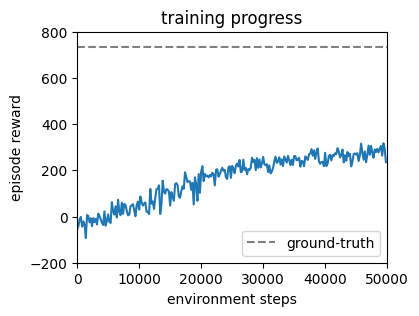

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
xdata, ydata = [], []
def progress(global_step, episodic_return):
    xdata.append(global_step)
    ydata.append(episodic_return)
    clear_output(wait=True)
    plt.figure(figsize=(4,3))
    plt.plot(xdata, ydata)

    xs = np.arange(total_timesteps)
    ys = np.ones((total_timesteps,)) * sim_reward_sum
    plt.plot(xs, ys, color="gray", linestyle="--", label="ground-truth")
    plt.legend()
    plt.xlim([0, total_timesteps])
    plt.ylim([-200, 800])
    plt.xlabel('environment steps')
    plt.ylabel('episode reward')
    plt.title('training progress')
    plt.show()


steps_log = []
rewards_log = []

for global_step in range(0, total_timesteps, episode_length):

    if global_step <= learning_starts:
        key, subkey = jax.random.split(key)
        obss, actions, rewards = random_rollout(subkey)

    else:
        key, subkey = jax.random.split(key)
        obss, actions, rewards = policy_rollout(subkey, dynamics_state, reward_state)

    rb.add(obss, actions, rewards)
    episodic_return = np.sum(rewards)
    progress(global_step, episodic_return)

    train_metrics = {}
    if global_step >= learning_starts:
        num_updates = learning_starts if global_step == learning_starts else episode_length
        for i in tqdm(range(num_updates)):

            # バッファからサンプルを取得
            samples = rb.sample(batch_size, horizon)

            # 環境モデルを更新
            dynamics_state, reward_state, loss_value = \
                update_dynamics(dynamics_state, reward_state, *samples)

### 学習結果の可視化

In [ ]:
# 結果の描画
key, subkey = jax.random.split(key)
env_state = env_reset(subkey)
rollout = [env_state.pipeline_state]

actions_mean = jnp.zeros((horizon, action_dim))
reward_sum = 0.0
for _ in tqdm(range(episode_length)):

    key, subkey = jax.random.split(key)
    action, actions_mean = mppi_with_model(
            subkey,
            env_state.obs,
            dynamics_state,
            reward_state,
            actions_mean,
            exploration_std=0.0
    )
    env_state = env_step(env_state, action)
    reward_sum += env_state.reward
    rollout.append(env_state.pipeline_state)

    actions_mean = jnp.concatenate([actions_mean[1:], jnp.zeros((1, action_dim))])

print(f"reward_sum: {reward_sum}")
HTML(html.render(env.sys.replace(dt=env.dt), rollout))

  0%|          | 0/200 [00:00<?, ?it/s]

reward_sum: 274.4688720703125
